In [1]:
import torch 
import torch.nn as nn
import time 
from time import sleep
import datetime
import os 
import numpy as np 
import torch.optim as optim
import matplotlib.pyplot as plt 
from torch.utils.data import DataLoader 
from sklearn.model_selection import train_test_split
import pandas as pd
import TrainHelper as th
import CustomModels as cm
import CustomImageDataset as cid
import LossFunction as lf 
import sys
import glob
sys.path.append(os.path.join('..','segment-utils'))
import VideoAnnotationHelper as vah

device = ("cuda" if torch.cuda.is_available() else "cpu")

C:\Users\bajajp\AppData\Local\anaconda3\envs\Xmen\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
C:\Users\bajajp\AppData\Local\anaconda3\envs\Xmen\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please

In [2]:
# If you are training finetune 
fineTune = False  
model_path = "//cgmqnap.clearguide.local/data/Needles/Lumena/models/shaft_segmentation/model_cyc_3_ep_200_bs_32_lr_0.001_20240108_T165341.pt"

transferLearning = True   
transfer_model_path = "//cgmqnap.clearguide.local/data/Needles/Lumena/models/shaft_segmentation/model_cyc_3_ep_200_bs_128_lr_0.001_20240124_T140745.pt"

batch_size = 128
epochs = 200
cycles = 3

encoder_lr = 1e-3
decoder_lr = 1e-3

lossFun1 = lf.IoULoss()
lossFun2 = lf.IoULoss()

parent_dir = "C:/Lumena/"
train_data_folder = "train_data"

img_dir = ["images_cropped_256x256"]
mask_dir = ["masks_cropped_256x256"]
mask_hubdir = ["masks_hub_cropped_256x256"]

observe_path="D:/test_dir"

In [3]:
sub_folders = ["EL/temp/", "PC_2/temp/", "PR/temp/", "EL_2/temp/", "CNMC/temp/", "CNMC_2/temp/", "SS/temp/", "Bob/temp/","PB/temp/", "PF/temp/"]

images_path = []
labels = []
                
for k in range(len(sub_folders)):
    img1 = glob.glob(parent_dir + "/" + train_data_folder + "/" + sub_folders[k] + img_dir[0] + "/*.png")
    lab1 = glob.glob(parent_dir + "/" + train_data_folder + "/" + sub_folders[k] + mask_dir[0] + "/*.png")
    lab2 = glob.glob(parent_dir + "/" + train_data_folder + "/" + sub_folders[k] + mask_hubdir[0] + "/*.png")
    
    for s in range(len(lab1)):
        labels.append([lab1[s], lab2[s]])
        images_path.append(img1[s])
    

X_train, X_val, y_train, y_val = train_test_split(images_path, labels, test_size = 0.2)



train_dataset = cid.CustomImageGray_2MaskDataset_dataAugmentation(X_train, y_train, ifgray = False, ifTrain = True)
val_dataset = cid.CustomImageGray_2MaskDataset_dataAugmentation(X_val, y_val, ifgray = False, ifTrain = True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True,num_workers=4,pin_memory = True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size, shuffle = False,num_workers=4,pin_memory = True)

In [4]:
if fineTune: 
    print("Model loaded for finetune")
    model = torch.jit.load(model_path)
else: 
    model = cm.NeedleSegmentationModel_1().to(device)

In [5]:
if transferLearning: 
    print("Old model weights transfered")
    old_model = torch.jit.load(transfer_model_path)
    model.load_state_dict(old_model.state_dict(), strict=False)

In [6]:
i = 0
for name, param in model.named_parameters():
    if param.requires_grad == True:
        print("NO.", i, name)
        i += 1

NO. 0 conv1.0.conv_block.0.conv_block.0.weight
NO. 1 conv1.0.conv_block.0.conv_block.0.bias
NO. 2 conv1.0.conv_block.0.conv_block.1.weight
NO. 3 conv1.0.conv_block.0.conv_block.1.bias
NO. 4 conv1.1.residual_layer.0.weight
NO. 5 conv1.1.residual_layer.0.bias
NO. 6 conv1.1.residual_layer.1.weight
NO. 7 conv1.1.residual_layer.1.bias
NO. 8 conv2.0.conv_block.0.conv_block.0.weight
NO. 9 conv2.0.conv_block.0.conv_block.0.bias
NO. 10 conv2.0.conv_block.0.conv_block.1.weight
NO. 11 conv2.0.conv_block.0.conv_block.1.bias
NO. 12 conv2.1.residual_layer.0.weight
NO. 13 conv2.1.residual_layer.0.bias
NO. 14 conv2.1.residual_layer.1.weight
NO. 15 conv2.1.residual_layer.1.bias
NO. 16 conv3.0.layer.0.group1.conv_block.0.weight
NO. 17 conv3.0.layer.0.group1.conv_block.0.bias
NO. 18 conv3.0.layer.0.group1.conv_block.1.weight
NO. 19 conv3.0.layer.0.group1.conv_block.1.bias
NO. 20 conv3.0.layer.0.group2.0.conv_block.0.conv_block.0.weight
NO. 21 conv3.0.layer.0.group2.0.conv_block.0.conv_block.0.bias
NO. 22

In [7]:
model_name = "model" 
model_name += "_cyc_" + str(cycles) + "_ep_" + str(epochs) + "_bs_" + str(batch_size)
model_name += "_lr_" + str(encoder_lr)
model_folder = model_name +  "_{:%Y%m%d_T%H%M%S}".format(datetime.datetime.now())

vah.createFolder(observe_path + "/"  + model_folder)

Created folder 'D:/test_dir/model_cyc_3_ep_200_bs_128_lr_0.001_20240124_T121955'.


In [8]:
# encoder_lr = 1e-4
# decoder_lr = 1e-4 

In [9]:
encoder_lr

0.001

In [10]:
for j in range(cycles):
        
    print("Training Cycle: ", j+1)

#     optimizer = torch.optim.Adam([{"params":encoder_list, "lr":encoder_lr},
#                                   {"params":decoder_list, "lr":decoder_lr}
#                                  ])

    optimizer = torch.optim.Adam(model.parameters(), lr = encoder_lr)
    
    early_stopping = th.EarlyStopping(patience = 20, min_delta = 0.01)

    for epoch in range(epochs): 
        train_loss = 0.0
        val_loss = 0.0

        start_time = time.time() 
        
        model.train()
        for data in train_loader: 
            images, labels, hub_labels = data 
            images = images.to(device)
            labels = labels.to(device)
            hub_labels= hub_labels.to(device)

            optimizer.zero_grad()
            output1, output2 = model(images)

            loss1 = lossFun1.forward(output1, labels)
            loss2 = lossFun2.forward(output2, hub_labels)
            
            loss = 0.5 * loss1 + 0.5 * loss2 
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval() 
        for data in val_loader: 

            
            images, labels, hub_labels = data 
            images = images.to(device)
            labels= labels.to(device)
            hub_labels= hub_labels.to(device)
            
            
            with torch.no_grad(): 
                output1, output2 = model(images)
                loss1 = lossFun1.forward(output1, labels)
                loss2 = lossFun2.forward(output2, hub_labels)
                
                loss = 0.5 * loss1 + 0.5 * loss2 
                
            val_loss += loss.item()

        train_loss = train_loss/len(train_loader)    
        val_loss = val_loss/len(val_loader)

        print('Epoch: {}  \tTraining Loss: {:.6f} \t Vali Loss: {:.6f} \t Exe Time: {:.6f}sec'.format(
        epoch, 
        train_loss, 
        val_loss,
        time.time() - start_time))

        stop = early_stopping.early_stop(val_loss, model)
        if stop: 
            model = early_stopping.get_model() 
            print("Early Stopping")
            encoder_lr /= 10
            decoder_lr /= 10
            break 

        if epoch % 10 == 0: 

            model_script = torch.jit.script(model)
            temp_name = model_name + "_{:%Y%m%d_T%H%M%S}".format(datetime.datetime.now()) + ".pt"
            model_script.save(observe_path + "/"  + model_folder + "/" + temp_name)
            print("Temprary model saved: ", temp_name)

Training Cycle:  1
Epoch: 0  	Training Loss: 0.980146 	 Vali Loss: 0.983363 	 Exe Time: 22.123578sec
Temprary model saved:  model_cyc_3_ep_200_bs_128_lr_0.001_20240124_T122047.pt
Epoch: 1  	Training Loss: 0.974337 	 Vali Loss: 0.982962 	 Exe Time: 19.592619sec
Epoch: 2  	Training Loss: 0.972423 	 Vali Loss: 0.980430 	 Exe Time: 19.231071sec
Epoch: 3  	Training Loss: 0.968510 	 Vali Loss: 0.978697 	 Exe Time: 19.120666sec
Epoch: 4  	Training Loss: 0.962724 	 Vali Loss: 0.978727 	 Exe Time: 19.389660sec
Epoch: 5  	Training Loss: 0.950344 	 Vali Loss: 0.978498 	 Exe Time: 19.409689sec
Epoch: 6  	Training Loss: 0.931180 	 Vali Loss: 0.977695 	 Exe Time: 19.666623sec
Epoch: 7  	Training Loss: 0.916681 	 Vali Loss: 0.969330 	 Exe Time: 19.317417sec
Epoch: 8  	Training Loss: 0.904695 	 Vali Loss: 0.968206 	 Exe Time: 19.416898sec
Epoch: 9  	Training Loss: 0.902958 	 Vali Loss: 0.931860 	 Exe Time: 19.193556sec
Epoch: 10  	Training Loss: 0.887999 	 Vali Loss: 0.947283 	 Exe Time: 19.469187sec


Temprary model saved:  model_cyc_3_ep_200_bs_128_lr_0.001_20240124_T125455.pt
Epoch: 91  	Training Loss: 0.439910 	 Vali Loss: 0.507103 	 Exe Time: 25.167949sec
Epoch: 92  	Training Loss: 0.450439 	 Vali Loss: 0.509885 	 Exe Time: 29.951655sec
Epoch: 93  	Training Loss: 0.433520 	 Vali Loss: 0.492609 	 Exe Time: 29.360834sec
Epoch: 94  	Training Loss: 0.443667 	 Vali Loss: 0.517246 	 Exe Time: 30.204447sec
Epoch: 95  	Training Loss: 0.442240 	 Vali Loss: 0.501745 	 Exe Time: 29.341625sec
Epoch: 96  	Training Loss: 0.448306 	 Vali Loss: 0.508004 	 Exe Time: 25.698683sec
Epoch: 97  	Training Loss: 0.435972 	 Vali Loss: 0.484240 	 Exe Time: 25.122057sec
Epoch: 98  	Training Loss: 0.452251 	 Vali Loss: 0.555018 	 Exe Time: 27.176304sec
Epoch: 99  	Training Loss: 0.450115 	 Vali Loss: 0.517017 	 Exe Time: 33.225860sec
Epoch: 100  	Training Loss: 0.438297 	 Vali Loss: 0.531260 	 Exe Time: 28.579547sec
Temprary model saved:  model_cyc_3_ep_200_bs_128_lr_0.001_20240124_T125939.pt
Epoch: 101  	

Epoch: 52  	Training Loss: 0.377316 	 Vali Loss: 0.430585 	 Exe Time: 23.243531sec
Epoch: 53  	Training Loss: 0.376935 	 Vali Loss: 0.449813 	 Exe Time: 24.501865sec
Epoch: 54  	Training Loss: 0.379910 	 Vali Loss: 0.447837 	 Exe Time: 27.875115sec
Epoch: 55  	Training Loss: 0.374514 	 Vali Loss: 0.452032 	 Exe Time: 26.802628sec
Epoch: 56  	Training Loss: 0.371549 	 Vali Loss: 0.438699 	 Exe Time: 23.959199sec
Epoch: 57  	Training Loss: 0.378419 	 Vali Loss: 0.434457 	 Exe Time: 22.986879sec
Epoch: 58  	Training Loss: 0.389897 	 Vali Loss: 0.439664 	 Exe Time: 23.105057sec
Epoch: 59  	Training Loss: 0.396851 	 Vali Loss: 0.444461 	 Exe Time: 22.684303sec
Epoch: 60  	Training Loss: 0.385859 	 Vali Loss: 0.434608 	 Exe Time: 22.958169sec
Temprary model saved:  model_cyc_3_ep_200_bs_128_lr_0.001_20240124_T134126.pt
Epoch: 61  	Training Loss: 0.375136 	 Vali Loss: 0.449196 	 Exe Time: 22.671270sec
Epoch: 62  	Training Loss: 0.381230 	 Vali Loss: 0.439453 	 Exe Time: 22.595728sec
Epoch: 63

In [11]:
model_script = torch.jit.script(model)
final_model = model_name + "_{:%Y%m%d_T%H%M%S}".format(datetime.datetime.now())
if fineTune: 
    final_model += "finetuned.pt"
else: 
    final_model += ".pt"

model_script.save("//cgmqnap.clearguide.local/data/Needles/Lumena" + "/models/shaft_segmentation/" + final_model)
print("Saved trained model: ", final_model)

Saved trained model:  model_cyc_3_ep_200_bs_128_lr_0.001_20240124_T140745.pt


### Test

In [12]:
data = iter(train_loader)
images, labels, hub_labels = next(data) 
images = images.to(device)
labels = labels.to(device)
hub_labels= hub_labels.to(device)

output1, output2 = model(images)

In [13]:
hub_labels = np.transpose(hub_labels.detach().cpu().numpy()[0],(1,2,0))

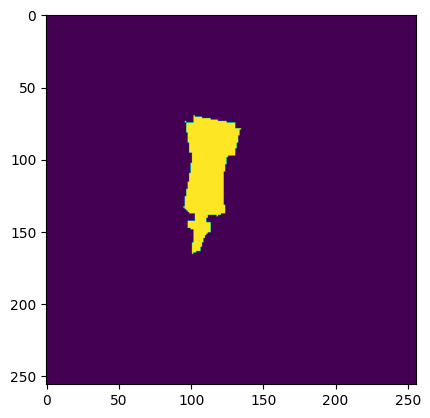

In [14]:
plt.imshow(hub_labels)

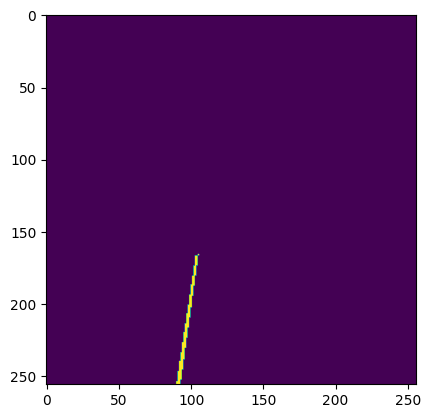

In [15]:
labels = np.transpose(labels.detach().cpu().numpy()[0],(1,2,0))
plt.imshow(labels)

In [16]:
output1.size()


torch.Size([128, 1, 256, 256])

In [17]:
output = np.transpose(output1.detach().cpu().numpy()[0],(1,2,0))

In [18]:
np.shape(output)

(256, 256, 1)

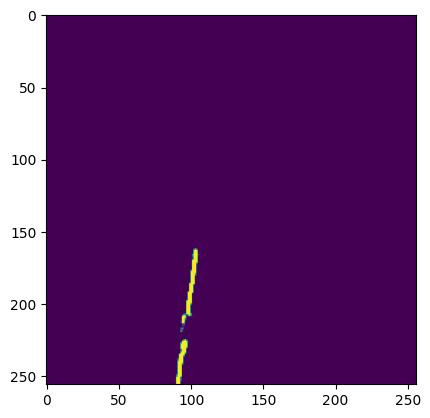

In [19]:
plt.imshow(output)

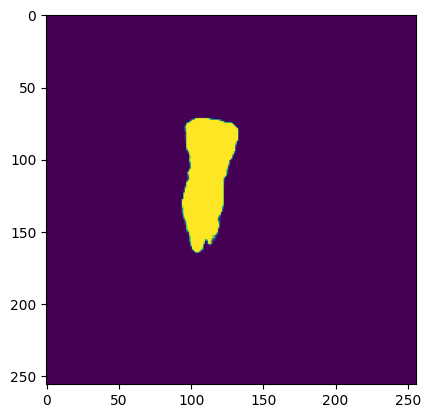

In [20]:
output2 = np.transpose(output2.detach().cpu().numpy()[0],(1,2,0))
plt.imshow(output2)